# Active Network Management | ANM of LV Networks - Rule Based Approach

## 1. Introduction 

### Objectives 
The objectives of this tutorial are:
1. To familiarise with the process by which power engineers can assess the benefits from adopting active network management solutions in LV networks with solar PV. To achieve this, you will investigate how the flexibility of certain network elements or technologies can be exploited to improve voltages.

2. To continue familiarising with the advanced tool [OpenDSS](https://www.epri.com/pages/sa/opendss) (using Python and the [dss_python](https://github.com/dss-extensions/dss_python) module). And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

### Structure of this Notebook
The rest of this notebook is divided into three parts:

- **2. Tutorial.** You will learn how to model a distribution transformer's OLTC and how to change the taps so that the voltage profiles are within the statutory limits.
- **3. Exercises.** Here you will go through some exercises that will help you familiarise with the code and how to modify it for different purposes.
- **4. Simulation Workspace.** Here you can place all your code to run it at once. You should use **`code`** that is relevant to each question 

<font color='red'>**<u>Note</u>:**</font> Make sure to understand well how to model the network, particularly how to model the OLTC, because this will be crucial to go through the exercises. If you make a mistake when modelling the network, your results will be incorrect.

## 2. Tutorial   

We will use the Test LV Circuit (shown in the figure below) from the [Tutorial-DERHostingCapacity-2-TimeSeries_LV](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV).  

Since you have already been working with this Test LV Circuit, only the information related to the transformer's on-load tap changer will be given in detail. 

<img style="float: middle;" src="LVcircuit-topology.png" width="50%">  

**<center>Figure 1. Test LV Circuit Topology</center>**   

A simple distribution transformer transforms voltages without any flexibility. But in many countries, including Australia, it is common to have a bit of flexibility in the form of **off-load tap changers**. The transformer needs to be off-load (disconnected) to change the tap to the desired position (the desired transformation ratio). The number of positions is, however, very limited (e.g., -5%, -2.5%, 0%, +2.5%, +5%). In the last decade, **OLTCs, a technology common in primary substations (or zone substation as known in Australia), are also available for distribution transformers**. This means we can set a voltage target and thanks to  multiple positions and the on-load capabilities, the secondary side can keep a desired voltage.

**In this tutorial we will simply show you how to code the OLTC. You will explore the use of the OLTC in the exercises.**

Follow the steps below. **And let's begin!**

<font color='red'>**<u>Note</u>:**</font> You will need to run the code in each cell. Select the code cell (a <font color='green'>**green box [ ]**</font> surrounding the cell will appear) and then click on the &#9654; **`Run`** button on top of the page to run the corresponding code (or use the shortcut `Control`-`Enter`). Since you will be running code, **you will need to run the cells sequentially**, one after the other without skipping code cells. A number will appear inside the brackets [X] indicating the number of the *run*.

### 2.1 Load Modules and Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
import dss
from random import choice

<a id='4'></a>
### 2.2 Set the working path
Run the code in the cell below to get your working path. As an output you get the location of this notebook in your computer.  

<font color='red'>**<u>Note 1</u>:**</font> Your path should not have spaces. Here is an example with no spaces: `C:\Users\name\Desktop\FolderX`.

<font color='red'>**<u>Note 2</u>:**</font> If you are a MAC user, there may be some errors due to the different use of slash/backslash when defining a path. By changing `/` instead of `\`, you will fix the problem. For instance, you can change `\\Residential..` with `/Residential..`.

<font color='red'>**<u>Note 3</u>:**</font> You should always open the Jupyter Notebook file from the folder that you uploaded to Jupyter Notebook. If you want to continue working later, you can simply save the changes and then open the **.ipynb** file again and continue working from where you left.

In [2]:
mydir = os.getcwd()
print(f"The direction is located in the following path: my_directory = {mydir}")

The direction is located in the following path: my_directory = C:\Users\ASIMONOVSKA\Documents\GitHub\ELEN90077_2024_Workshop-Week4-Active-Network-Management


### 2.3 Set up dss_engine

In [3]:
dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = dss_engine.ActiveCircuit.Solution
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue
dss_engine.AllowForms = 0

### 2.4 Network, Load and solar PV Modelling
#### 2.4.1 Define components
The `LVcircuit-master.txt` file defines the frequency and base voltages, then it redirects to network components definitions: transformers, lines, loads, etc.  

In [4]:
DSSText.Command = 'Clear'                               
DSSText.Command = 'Compile ' + mydir +  '\\TestLVCircuit\\LVcircuit-master.txt'    
DSSText.Command = 'Set VoltageBases = [22.0, 0.400]'
DSSText.Command = 'calcvoltagebases'

#### 2.4.2 Import Load and PV profiles and store their shapes

In [5]:
houseData30minutes = np.load(mydir + '\\TestLVCircuit\\Residential load data 30-min resolution.npy') 
PVData30minutes = np.load(mydir + '\\TestLVCircuit\\Residential PV data 30-min resolution.npy')

In [6]:
shape_profiles  = houseData30minutes.shape
noProfiles = shape_profiles[0]
PV_shape_profiles  = PVData30minutes.shape

x=[i for i in range(48)]
l=[]
for i in range(24): 
      l.append("%s:00"%i)
      l.append(" ")

### 2.5 Definition of Functions

#### 2.5.1 def <font color=blue> Load_profile_allocation</font> (New,icust,cust,iday)

In [7]:
def Load_profile_allocation(New,icust,cust,iday):
    if New==1:
       load_profile = np.zeros(48)
       DSSCircuit.LoadShapes.New('customer_profile_%s' %(icust))
       DSSCircuit.LoadShapes.Npts = 48
       DSSCircuit.LoadShapes.MinInterval = 30
       DSSCircuit.LoadShapes.UseActual = 1
       DSSCircuit.LoadShapes.Qmult = (load_profile * math.tan(math.acos(0.95))).tolist()
    
    else:
        random_profile = np.random.randint(0,noProfiles)        
        load_profile = houseData30minutes[random_profile, iday, :]
        reactive_profile = []
        for j in range(48):
            reactive_profile.append((load_profile[j]) * math.tan(math.acos(keep_power_factor[icust][j])))
        reactive_profile = np.array(reactive_profile)          
        DSSCircuit.LoadShapes.Qmult = reactive_profile.tolist()
        
        
    DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(icust)
    DSSCircuit.LoadShapes.Pmult = load_profile.tolist()  
    DSSCircuit.SetActiveElement('load.%s'%(cust))
    DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(icust))
    if New==0:
        return (load_profile,reactive_profile,random_profile)

#### 2.5.2 def <font color=blue> PV_allocation</font> (New,icust,cust,iday)

In [8]:
def PV_allocation(New,icust,cust,iday):
    if New==1:
        PV_profile = np.zeros(48)
        DSSCircuit.LoadShapes.New('pv_profile_%s' %(icust))
        DSSCircuit.LoadShapes.Npts = 48
        DSSCircuit.LoadShapes.MinInterval = 30
        DSSCircuit.LoadShapes.UseActual = 1
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
        DSSCircuit.SetActiveElement('load.%s' %(cust))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
        DSSText.Command = 'new PVSystem.%s'%(icust)\
                                + ' phases = 1'  \
                                + ' irradiance = 1' \
                                + ' %cutin = 0.05' \
                                + ' %cutout = 0.05' \
                                + ' vmaxpu = 1.5' \
                                + ' vminpu = 0.5' \
                                + ' kva = 10' \
                                + ' pmpp = 10'\
                                + ' bus1 = ' + str(bus_name)\
                                + ' pf = 1' \
                                + ' kv = 0.23' \
                                + ' daily = ' +str('pv_profile_%s'%(icust))
    else:
        PV_profile = PVData30minutes[iday,:]
        pv_profiles_all.append(PV_profile)        
        DSSCircuit.LoadShapes.Name = 'pv_profile_%s' %(icust)
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()        
        DSSCircuit.SetActiveElement('load.%s' %(cust))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
        DSSCircuit.SetActiveElement('PVSystem.%s'%(icust))
        DSSCircuit.ActiveElement.Properties('bus1').Val = str(bus_name)
        DSSCircuit.ActiveElement.Properties('daily').Val = str('pv_profile_%s'%(icust))
        return PV_profile

#### 2.5.3 def <font color=blue>Initiate_variable</font> (customers)

In [9]:
def Initiate_variable(customers):
    kW_monitors = np.zeros((customers,48))
    kvar_monitors = np.zeros((customers,48))
    voltages_monitors = np.zeros((customers,48))
    df_kw = pd.DataFrame()
    df_kvar = pd.DataFrame()
    df_volt = pd.DataFrame()
    load_profiles_all = []
    pv_profiles_all = []
    random_profiles_all = []    
    rand_cust = []  
    reactive_profiles_all = []
    return  (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, 
             df_volt, load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust,reactive_profiles_all)

#### 2.5.4 def <font color=blue>Monitors_data</font> ()

In [10]:
def Monitors_data():
    for icust, cust in enumerate(Loadname):
            DSSCircuit.SetActiveElement('load.%s' %(cust))
            kW_monitors[icust, itime] = DSSCircuit.ActiveElement.Powers[0]
            kvar_monitors[icust,itime]= DSSCircuit.ActiveElement.Powers[1]
            bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
            DSSCircuit.SetActiveBus(bus_name)
            voltages_monitors[icust, itime] = DSSCircuit.ActiveBus.puVmagAngle[0]

### 2.6 Simulation and Results
- <font color='red'>**<u>Note</u>:**</font> Here starts the most important part of this workshop.

#### 2.6.1  Set simulation period
- Set `start_day` and `total_day` to choose the simulation period you want.  
- The start_day will be given in the Questions, so use the **exact day** provided.
- You will run the simulation for the given day only, so `total_days` will be equal to 1.

In [11]:
start_day = 250
total_days = 1

#### 2.6.2 Set PV penetration level
- Depending on the type of analysis, use the relevant PV penetration. 
- You may have a case **without solar PV systems**, therefore `penetration=0`

In [12]:
penetration = 0
Loadname = DSSCircuit.Loads.AllNames
num_cust = len(Loadname)*(penetration/100)

#### 2.6.3 Initialise Load profiles and PV systems
After defining the functions, we are ready to allocate the Load and PV profiles

In [13]:
for icust, cust in enumerate(Loadname):
    Load_profile_allocation(1,icust,cust,0)  
    if num_cust>0:
        PV_allocation(1,icust,cust,0)

#### 2.6.4 Generate a random power factor list

In [14]:
keep_power_factor = []
customers = len(Loadname)
for i in range(total_days*customers):
    keep_pf = []
    for j in range(48):
        random_pf = random.uniform(0.9,0.98)
        keep_pf.append(random_pf)
    keep_power_factor.append(keep_pf)

### 2.7 Creating and controlling the OLTC
The voltages in the Test LV Circuit (and any distribution network) should always be within the corresponding statutory limits. A distribution transformer with an OLTC can help you regulating voltages. Of course, this will all depend on how you decide to control it.

In OpenDSS, we need to create a voltage regulator. Below are the settings for the OLTC in our Test LV Circuit:

- **`New RegControl.OLTC`** creates a voltage regulator named "OLTC".
- **`Transformer=transformer_MG1_TR1`** sets the voltage regulator to regulate voltages at transformer TR1.
- **`Winding=2`** sets the winding of the transformer where the voltage is being controled.
- **`TapWinding=1`** sets the winding of the transformer where the taps are connected to.
- **`Vreg=(102)`** sets the voltage on the controlled bus (the secondary side) at 1.02pu. In case you need to set the voltage at 1pu, you just have to use 100. The same principle is valid for other values.
- **`PTRatio=(400 3 sqrt / 100 /)`** sets the ratio of the potential transformer (**do not change this value**).
- **`Band=1`** sets the bandwidth for the controlled bus (**do not change this value**).

<font color='purple'>**<u>Tech Note 1</u>:**</font> Why is 100 equivalent to 1pu in the Vreg? In reality, the voltage being sensed can be after a little voltage transformer (yes, to make the voltage even smaller for sensors). And it's that little voltage that then the controller uses as a reference. In our case, because of the values we are using in the PTRatio (the transformer for the single-phase sensor), we can confidently say that 100 is equivalent to 400V line-to-line or 230V line-to-neutral.

<font color='purple'>**<u>Tech Note 2</u>:**</font> Then, does band=1 mean the voltage we are OK with are from 1.01pu to 1.03pu? No. That 1 is for the whole band. So, it means the voltages we are OK with are from 1.015pu to 1.025pu. If the voltage at the secondary is not within that range, then the OLTC will change the tap position.

<font color='red'>**<u>Note 1</u>:**</font> Although the settings are explained here in a separated way, do not separate them in the code. The code should be as on the next cell.

<font color='red'>**<u>Note 2</u>:**</font> You will have to use the voltage regulator when asked in the exercises. So, when needed, you should uncomment the line, by deleting the `#` symbol.

In [15]:
#DSSText.Command =  'New RegControl.OLTC Transformer=transformer_MG1_TR1 Winding=2 TapWinding=1 Vreg=(102) PTRatio=(400 3 sqrt / 100 /) Band=1'

### 2.8 Daily power flow analysis 

The last part of the code plots the voltage profiles of all 31 single-phase customers. 

<font color='red'>**<u>Note</u>:**</font> To check compliance with the statutory limits, use the corresponding **value** (+10% or -6% for upper and lower limits, respectively) in the commented line of code <font color='blue'>plt.axhline(**value**, linewidth = 1,linestyle='dashed', color = 'r')</font>

This is day:  250
Message: The Solution Converged Successfully



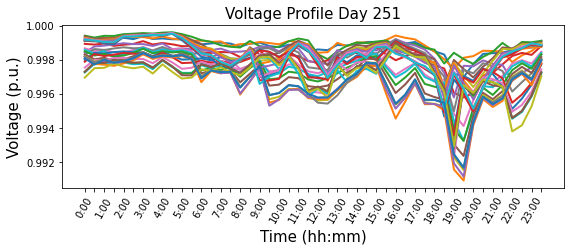

In [16]:
for iday in range(start_day,start_day+total_days):
    print("This is day: ",iday)
    np.random.seed(10)
    (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt, 
     load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust,reactive_profiles_all) = Initiate_variable(customers)

    for icust, cust in enumerate(Loadname):
        load_profile,reactive_profile,random_profile=Load_profile_allocation(0,icust,cust,iday)
        load_profiles_all.append(load_profile)
        reactive_profiles_all.append(reactive_profile)
        random_profiles_all.append(random_profile)
        random.seed(90)
        
    random_customer = np.array(Loadname)
    random.shuffle(random_customer) 
    
    for numb in range(round(num_cust)):                
         rand_cust.append(choice([PV_cust for PV_cust in random_customer if PV_cust not in rand_cust]))
         PV_allocation(0,numb,rand_cust[numb],iday)
         PV_profile=PV_allocation(0,numb,rand_cust[numb],iday)
         pv_profiles_all.append(PV_profile)   

    DSSText.Command = 'Reset'       
    DSSText.Command = 'Set Mode=daily  number=1 stepsize=30m' 
        
    for itime in range(48):
        DSSSolution.Solve()
        Monitors_data()
    df_kw=pd.DataFrame(kW_monitors)
    df_kvar=pd.DataFrame(kvar_monitors)
    df_volt=pd.DataFrame(voltages_monitors)    
    
    if DSSSolution.Converged:
         print('Message: The Solution Converged Successfully\n')
    else:
         print("Message: The Solution Did Not Converge\n") 
           
    
    fig=plt.figure(figsize=(9,3)) 
    for idx, row in df_volt[0:31].iterrows():
             plt.plot(np.array(row), linewidth = 2)         
             plt.xlabel("Time (hh:mm)", fontsize = 15)
             plt.xticks(fontsize = 10)
             plt.xticks(x,l, fontsize=10, rotation=60)
             plt.ylabel('Voltage (p.u.)', fontsize = 15)
             plt.yticks(fontsize = 10)
             plt.title("Voltage Profile Day %s"%(iday+1), fontsize = 15)
             #plt.ylim([0.9,1.13])
             #plt.axhline(1.10, linewidth = 1,linestyle='dashed', color = 'r')
    plt.show()   

## 3. Exercises

First, read all the exercises so you understand their purpose.

At the very end of this notebook in **4. Simulation Workspace**, you will be able to place all your code to run it at once. Remember, you should use **`code`** that is relevant to each exercise.

### **Exercise:Residential Solar PV Systems and Active Network Management**
In this exercise, you will use the LV network from Figure 1 and perfrom ANM.

Before starting, change the `LVcircuit-master.txt` file such that the 22kV of the transformer in the LVcircuit-transformers.txt are equal to `1.08pu` (as given in the figure below). This corresponds to the case when the transformer is closer to the primary substation.


<img style="float: middle;" src="TestLVCircuit\change_master2.png" width="50%">  

  

**E.1:** Set the PV penetration to **90%**. The upper and lower statutory voltage limits are +10%/- 6% of nominal. For the selected days given below, using the substation transformers’ ability to control the voltage of the secondary side (i.e., using on-load tap changer to control the voltage at secondary side), determine the voltage regulation value (i.e., only one value per season) for the on-load tap changer control that brings the voltage profiles of all 31 single-phase customers to values within the limits. Use regulation values that are apart by 0.00625pu and between 0.9pu and 1.1pu. For instance, 0.90625pu or 1.00625pu (of course, these are not the answers!). The regulation value that we are looking for is the highest one that leads to customer's voltage within the limits. 

- **Summer Day: `start_day=5`**
- **Winter Day: `start_day=168`**  


- `Note` that here it is expected that you provide one value for the summer season (by running simulations using the selected summer day) and one value for the winter season (by running simulations using the selected winter day). This is due to the fact that sometimes the taps of the transformer can be different, depending on the conditions. 


## 4. Simulation Workspace